In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
#csvのパスを設定
csv_path = "/Users/ishigurofutoshi/lab_materials/data/integrated_route.csv"

missing_rate_path = "/Users/ishigurofutoshi/lab_materials/data/missing_rate.xlsx"

In [49]:
df = pd.read_csv(csv_path,index_col=0)
# Slice [start:stop:step], starting from index 5 take every 6th record.
#df = df[5::6]
df = df.dropna(axis=1)
df.pop("5 Minutes")

0        2021-01-01 00:00:00
1        2021-01-01 00:05:00
2        2021-01-01 00:10:00
3        2021-01-01 00:15:00
4        2021-01-01 00:20:00
                ...         
25567    2021-07-31 03:35:00
25568    2021-07-31 03:40:00
25569    2021-07-31 03:45:00
25570    2021-07-31 03:50:00
25571    2021-07-31 03:55:00
Name: 5 Minutes, Length: 80100, dtype: object

In [50]:
target = "78"
n_input = 10
index_target = df.columns.get_loc(target)
n_min_ahead = 6
window_len = 24

In [51]:
df = df.reset_index(drop=True)

In [52]:
df

,11750,13147,13867,14467,14987,16207,16507,16509,16510,16511,...,79,80,81,82,83,84,85,86,87,88
0,16.88,34.90,8.62,19.35,7.00,21.43,30.88,30.22,35.87,40.30,...,30.15,29.38,36.30,35.93,11.78,11.87,16.80,16.73,15.92,12.12
1,16.97,34.87,8.65,19.35,7.00,21.42,30.87,29.98,35.92,40.37,...,30.15,29.37,36.37,35.88,11.82,11.88,16.80,16.78,15.87,12.12
2,16.98,34.95,8.67,19.38,7.00,21.43,30.82,30.07,36.02,40.43,...,30.17,29.27,36.23,35.88,11.82,12.07,16.83,16.77,15.85,12.15
3,16.98,35.05,8.67,19.43,7.02,21.37,30.85,30.15,36.13,40.55,...,30.15,29.13,36.27,35.98,11.82,11.92,16.82,16.70,15.83,12.18
4,16.90,35.03,8.68,19.53,7.03,21.40,30.88,30.28,36.27,40.68,...,29.97,29.02,36.37,36.08,11.85,11.92,16.83,16.73,15.88,12.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80095,17.15,35.30,8.60,19.42,7.22,21.57,30.62,30.30,36.15,40.72,...,30.65,30.08,36.03,36.00,11.78,12.03,16.82,17.02,15.52,12.78
80096,17.10,35.30,8.58,19.47,7.23,21.57,30.87,30.37,36.02,40.62,...,30.68,30.13,35.95,36.07,11.78,12.05,16.90,17.10,15.73,12.87
80097,17.32,35.28,8.60,19.43,7.22,21.82,31.45,31.00,36.17,40.82,...,30.52,30.03,36.02,35.98,11.82,12.00,16.87,17.17,15.63,12.78
80098,17.25,35.32,8.65,19.48,7.23,21.73,31.73,31.43,36.13,40.70,...,30.67,29.90,35.97,36.03,11.82,12.07,16.90,17.65,15.82,12.83


### 標準化

In [6]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
#train_df = df[0:int(n*0.9)]
#val_df = df[int(n*0.7):int(n*0.9)]
#test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [7]:
df_mean = df.mean()
df_std = df.std()

df = (df - df_mean) / df_std
#val_df = (val_df - train_mean) / train_std
#test_df = (test_df - train_mean) / train_std

## target missing

In [8]:
def select_index(df,target):

    #相互相関関数
    corrs = []
    lags = []
    for c in df.columns:
        xcorr_list = xcorr(df[target],df[c])
        lag = np.argmax(np.abs(xcorr_list))
        lags.append(lag)
        corr = corr_lag(df[target],df[c],lag)
        corrs.append(corr)
    corrs = np.array(corrs)
    lags = np.array(lags) #targetと各routeでのラグを格納
    
    #重要度の上位を出力
    idx_corrs = np.argsort(np.abs(corrs))[::-1]
    top_cols_corrs,top_importances_corrs,lags = df.columns.values[idx_corrs][1:n_input+1],corrs[idx_corrs][1:n_input+1],lags[idx_corrs][1:n_input+1]
    print(top_cols_corrs,top_importances_corrs,lags)
    
    #targetのインデックスを追加
    if target in top_cols_corrs:
        top_cols_corrs = np.delete(top_cols_corrs,[target])
    
    top_cols_select = top_cols_corrs
    
    return top_cols_select
    #return [str(target)]
    
def xcorr(target,c):
    xcorr_list = []
    #margin = np.zeros(24)
    #target = np.block([target,margin])
    #c = np.block([margin,c])
    
    for t in range(24):
        score = np.dot(target[t:],c[:len(c)-t])/(len(target)-t)
        xcorr_list.append(score)
        
    return xcorr_list

def corr_lag(target,c,lag):
    return np.corrcoef(target[lag:],c[:len(c)-lag])[0,1]

## target not missing

def select_index(df,target):

    #相互相関関数
    corrs = []
    lags = []
    for c in df.columns:
        xcorr_list = xcorr(df[target],df[c])
        lag = np.argmax(np.abs(xcorr_list))
        lags.append(lag)
        corr = corr_lag(df[target],df[c],lag)
        corrs.append(corr)
    corrs = np.array(corrs)
    lags = np.array(lags) #targetと各routeでのラグを格納
    
    #重要度の上位を出力
    idx_corrs = np.argsort(np.abs(corrs))[::-1]
    top_cols_corrs,top_importances_corrs,lags = df.columns.values[idx_corrs][:n_input],corrs[idx_corrs][:n_input],lags[idx_corrs][:n_input]
    print(top_cols_corrs,top_importances_corrs,lags)
    
    #targetのインデックスを追加
    if not target in top_cols_corrs:
        top_cols_corrs = np.append(top_cols_corrs,[target])
    
    top_cols_select = top_cols_corrs
    
    return top_cols_select
    #return [str(target)]
    
def xcorr(target,c):
    xcorr_list = []
    #margin = np.zeros(24)
    #target = np.block([target,margin])
    #c = np.block([margin,c])
    
    for t in range(24):
        score = np.dot(target[t:],c[:len(c)-t])/(len(target)-t)
        xcorr_list.append(score)
        
    return xcorr_list

def corr_lag(target,c,lag):
    return np.corrcoef(target[lag:],c[:len(c)-lag])[0,1]

### 欠損生成&補完

In [9]:
select_features = select_index(df,target)

['81' '275' '6225' '18830' '6224' '18828' '19835' '14467' '372' '2133'] [0.93080856 0.9187865  0.91254206 0.91001707 0.9052869  0.90467683
 0.89662424 0.88076174 0.87273251 0.87006175] [0 0 0 0 1 0 0 0 0 0]


#target not missing
df = df.loc[:,select_features]

In [10]:
#target missing
df = df.loc[:,np.append(select_features,target)] 

In [11]:
labels_df = df.loc[:,target]
inputs_df = df.loc[:,select_features]

#target not missing
import random
c = inputs_df.columns.get_loc(target)
median = inputs_df.iloc[:,c].median()
mean = inputs_df.iloc[:,c].mean()
min = inputs_df.iloc[:,c].min()
rep = min

for i in [random.randint(0,int(80100*0.9)) for i in range(int(80100*0.9*0.3))]:
    #if inputs_df.iloc[i,c] < median*10:
    labels_df.iloc[i] = rep
    inputs_df.iloc[i,c] = rep
for i in [random.randint(int(80100*0.9),80099) for i in range(int(80100*0.1*0.3))]:
    inputs_df.iloc[i,c] = rep

## データセット生成

In [12]:
def make_dataset(labels_df,inputs_df,window_len):
    labels, inputs = [], []
    for i in range(len(labels_df)-(window_len+n_min_ahead-1)):
        labels.append(labels_df.iloc[i+window_len+n_min_ahead-1])
        inputs.append(inputs_df.iloc[i:i+window_len])
    re_labels = np.array(labels).reshape(len(labels),1)
    re_inputs = np.array(inputs).reshape(len(inputs),window_len,n_input)
    
    return re_labels,re_inputs

In [13]:
labels_ds, inputs_ds = make_dataset(labels_df,inputs_df,window_len)

In [14]:
labels_ds.shape

(80071, 1)

In [15]:
inputs_ds.shape

(80071, 24, 10)

In [16]:
n = len(inputs_ds)
train_x, test_x = inputs_ds[:int(n*0.9)],inputs_ds[int(n*0.9):] 
train_y, test_y = labels_ds[:int(n*0.9)],labels_ds[int(n*0.9):]

In [17]:
train_x

array([[[-0.76263162, -0.76524017, -0.69745898, ..., -0.87047217,
         -0.82754916, -0.70362662],
        [-0.7554303 , -0.76026685, -0.67821042, ..., -0.87047217,
         -0.82754916, -0.73627298],
        [-0.76983294, -0.75197799, -0.66127169, ..., -0.86420818,
         -0.82504483, -0.7199498 ],
        ...,
        [-0.77497674, -0.77352904, -0.74904512, ..., -0.86629618,
         -0.82003615, -0.7743604 ],
        [-0.78012054, -0.76855572, -0.74750523, ..., -0.8558562 ,
         -0.82504483, -0.79068358],
        [-0.79040814, -0.76855572, -0.73364627, ..., -0.86420818,
         -0.82504483, -0.8015657 ]],

       [[-0.7554303 , -0.76026685, -0.67821042, ..., -0.87047217,
         -0.82754916, -0.73627298],
        [-0.76983294, -0.75197799, -0.66127169, ..., -0.86420818,
         -0.82504483, -0.7199498 ],
        [-0.7657179 , -0.75695131, -0.67436071, ..., -0.8537682 ,
         -0.82003615, -0.65465708],
        ...,
        [-0.78012054, -0.76855572, -0.74750523, ..., -

In [18]:
test_x

array([[[-0.6628419 , -0.63261831, -0.61276532, ..., -0.80783227,
         -0.78998409, -0.6614584 ],
        [-0.73176882, -0.62432944, -0.59736647, ..., -0.80783227,
         -0.78247108, -0.66825973],
        [-0.73176882, -0.60775171, -0.58350751, ..., -0.81200826,
         -0.77495806, -0.6927445 ],
        ...,
        [-0.59494373, -0.61106725, -0.52191212, ..., -0.69299245,
         -0.68730623, -0.62745178],
        [-0.45708988, -0.60775171, -0.51036299, ..., -0.68255246,
         -0.69982792, -0.57440145],
        [-0.42519832, -0.60775171, -0.48957454, ..., -0.6574965 ,
         -0.68730623, -0.57984251]],

       [[-0.73176882, -0.62432944, -0.59736647, ..., -0.80783227,
         -0.78247108, -0.66825973],
        [-0.73176882, -0.60775171, -0.58350751, ..., -0.81200826,
         -0.77495806, -0.6927445 ],
        [-0.67004322, -0.64588049, -0.59120693, ..., -0.80156828,
         -0.76994939, -0.67642132],
        ...,
        [-0.45708988, -0.60775171, -0.51036299, ..., -

In [19]:
# モデル構築

# 1つの学習データのwindowサイズ
length_of_sequence = inputs_ds.shape[1] 
in_out_neurons = 1
n_hidden = 300

model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, n_input), return_sequences=False))
model.add(Dense(in_out_neurons))
#model.add(Activation("linear"))
optimizer = Adam(learning_rate=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer)

2022-05-13 16:17:55.433535: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=5)
model.fit(train_x, train_y,
          batch_size=300,
          epochs=100,
          validation_split=0.1,
          callbacks=[early_stopping]
          )

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
217/217 [==============================] - ETA: 0s - loss: 0.1197WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fd9887a45f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

In [21]:
predicted = model.predict(test_x)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [22]:
len(predicted)

8008

In [23]:
len(test_y)

8008

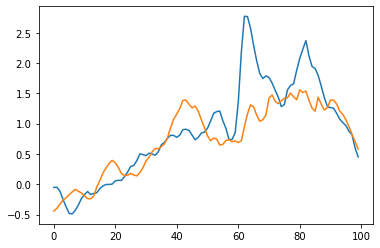

In [24]:
plt.plot(test_y[:100])
plt.plot(predicted[:100])

In [25]:
performance = model.evaluate(test_x,test_y, verbose=0)

In [26]:
performance

0.1760721206665039